# Comparing Simple RAG vs Contextual RAG

This notebook demonstrates the differences between the Simple RAG and Contextual RAG implementations using a small PDF document.

In [9]:
# Import necessary libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import time
import numpy as np
from IPython.display import Markdown, display

sys.path.append(os.path.abspath('..'))

# Import RAG modules
from simple_rag.modules.embedding import init_embeddings, init_llm as simple_init_llm
from simple_rag.modules.pdf_loader import PDFProcessor
from simple_rag.modules.qa_chain import QAChain as SimpleQAChain

from contextual_rag.modules.embedding import init_embeddings as contextual_init_embeddings
from contextual_rag.modules.embedding import init_llm as contextual_init_llm
from contextual_rag.modules.pdf_loader import ContextualPDFProcessor
from contextual_rag.modules.qa_chain import ContextualQAChain

# Load environment variables
load_dotenv()

# Check if API key is set
if "COHERE_API_KEY" not in os.environ:
    raise ValueError("Please set COHERE_API_KEY in your environment or .env file")

## 1. Setup RAG Systems

First, we'll initialize both RAG systems and process a small PDF file.

In [10]:
# Path to a small PDF for testing
pdf_path = "sample_document.pdf"

# If you don't have a PDF ready, let's create a simple one using reportlab
try:
    # Check if the PDF exists
    with open(pdf_path, "rb") as f:
        pass
except FileNotFoundError:
    from reportlab.lib.pagesizes import letter
    from reportlab.pdfgen import canvas
    from reportlab.lib.styles import getSampleStyleSheet
    from reportlab.platypus import Paragraph, SimpleDocTemplate, Spacer
    from reportlab.lib.units import inch
    
    doc = SimpleDocTemplate(pdf_path, pagesize=letter)
    styles = getSampleStyleSheet()
    
    story = []
    story.append(Paragraph("Machine Learning Overview", styles["Title"]))
    story.append(Spacer(1, 0.25*inch))
    
    paragraph1 = """Machine learning is a branch of artificial intelligence that focuses on building systems that learn from data. 
    It has applications in various fields including computer vision, natural language processing, and recommendation systems."""
    story.append(Paragraph(paragraph1, styles["Normal"]))
    story.append(Spacer(1, 0.25*inch))
    
    story.append(Paragraph("Supervised Learning", styles["Heading2"]))
    paragraph2 = """Supervised learning involves training models on labeled data. The model learns to map inputs to outputs based on example pairs. 
    Common algorithms include linear regression, logistic regression, support vector machines, and neural networks."""
    story.append(Paragraph(paragraph2, styles["Normal"]))
    story.append(Spacer(1, 0.25*inch))
    
    story.append(Paragraph("Unsupervised Learning", styles["Heading2"]))
    paragraph3 = """Unsupervised learning deals with unlabeled data. The system tries to learn the structure of the data without explicit guidance. 
    Examples include clustering algorithms like K-means and dimensionality reduction techniques like PCA."""
    story.append(Paragraph(paragraph3, styles["Normal"]))
    
    doc.build(story)
    print(f"Created sample PDF at {pdf_path}")
else:
    print(f"Using existing PDF at {pdf_path}")

Using existing PDF at sample_document.pdf


In [11]:
# Initialize Simple RAG
print("Initializing Simple RAG system...")
simple_embeddings = init_embeddings()
simple_llm = simple_init_llm()
simple_processor = PDFProcessor(simple_embeddings)
simple_documents = simple_processor.load_and_process(pdf_path)
simple_qa = SimpleQAChain(simple_processor.vector_store, simple_llm)

# Initialize Contextual RAG
print("\nInitializing Contextual RAG system...")
contextual_embeddings = contextual_init_embeddings()
contextual_llm = contextual_init_llm()
contextual_processor = ContextualPDFProcessor(contextual_embeddings, contextual_llm)
contextual_documents = contextual_processor.load_and_process(pdf_path)
contextual_qa = ContextualQAChain(contextual_processor.vector_store, contextual_llm)

Initializing Simple RAG system...

Initializing Contextual RAG system...
Document split into 1 chunks.
Generating contextual embeddings for 1 chunks...
Processing chunk 1/1


## 2. Architecture Comparison

Let's visualize the architectural differences between Simple RAG and Contextual RAG.

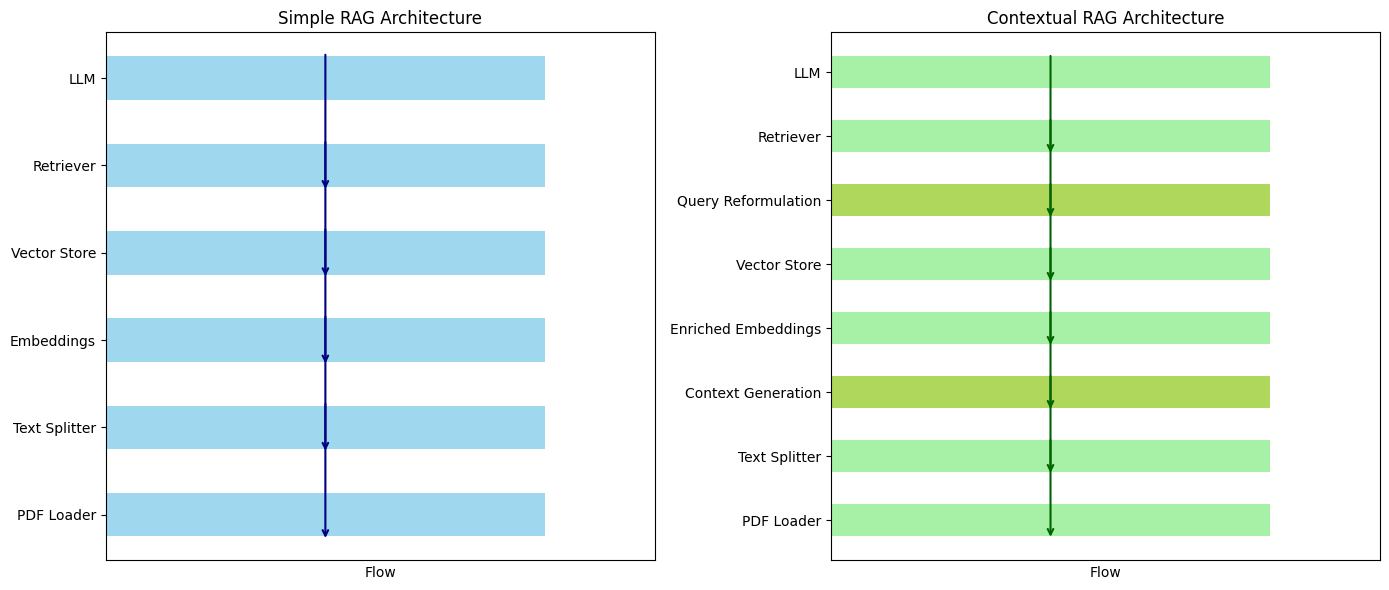

In [12]:
# Create architecture comparison diagram using matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Simple RAG Architecture
simple_components = ['PDF Loader', 'Text Splitter', 'Embeddings', 'Vector Store', 'Retriever', 'LLM']
simple_y = np.arange(len(simple_components))
simple_colors = ['skyblue'] * len(simple_components)

ax1.barh(simple_y, [0.8] * len(simple_components), height=0.5, color=simple_colors, alpha=0.8)
ax1.set_yticks(simple_y)
ax1.set_yticklabels(simple_components)
ax1.set_xlabel('Flow')
ax1.set_title('Simple RAG Architecture')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.set_xticks([])

# Add arrows for flow
for i in range(len(simple_components) - 1):
    ax1.annotate('', xy=(0.4, simple_y[i] - 0.3), xytext=(0.4, simple_y[i+1] + 0.3),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='navy'))

# Contextual RAG Architecture
contextual_components = ['PDF Loader', 'Text Splitter', 'Context Generation', 'Enriched Embeddings', 
                         'Vector Store', 'Query Reformulation', 'Retriever', 'LLM']
contextual_y = np.arange(len(contextual_components))
contextual_colors = ['lightgreen'] * len(contextual_components)
contextual_colors[2] = 'yellowgreen'  # Highlight the context generation step
contextual_colors[5] = 'yellowgreen'  # Highlight the query reformulation step

ax2.barh(contextual_y, [0.8] * len(contextual_components), height=0.5, color=contextual_colors, alpha=0.8)
ax2.set_yticks(contextual_y)
ax2.set_yticklabels(contextual_components)
ax2.set_xlabel('Flow')
ax2.set_title('Contextual RAG Architecture')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', linestyle='--', alpha=0.6)
ax2.set_xticks([])

# Add arrows for flow
for i in range(len(contextual_components) - 1):
    ax2.annotate('', xy=(0.4, contextual_y[i] - 0.3), xytext=(0.4, contextual_y[i+1] + 0.3),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='darkgreen'))

plt.tight_layout()
plt.show()

## 3. Document Processing Comparison

Let's compare how each system processes documents by looking at chunk sizes and enrichment.

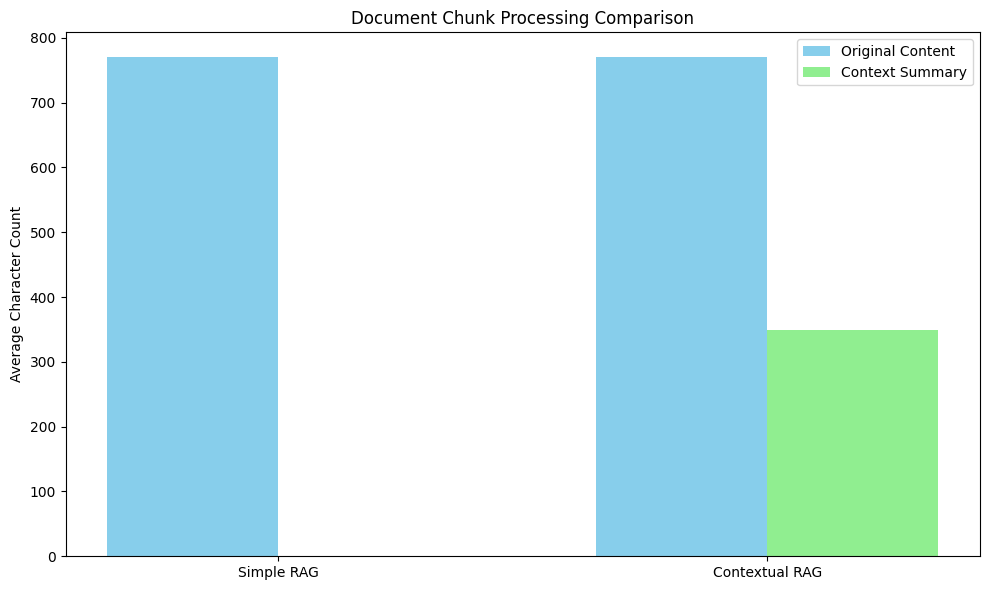

In [13]:
# Analyze document processing differences
simple_chunk_lengths = [len(doc.page_content) for doc in simple_documents]
simple_avg_length = sum(simple_chunk_lengths) / len(simple_chunk_lengths) if simple_chunk_lengths else 0

contextual_chunk_lengths = []
contextual_context_lengths = []
contextual_content_lengths = []

for doc in contextual_documents:
    contextual_chunk_lengths.append(len(doc.page_content))
    # Extract context and content portions if available
    if "original_content" in doc.metadata and "context_summary" in doc.metadata:
        contextual_content_lengths.append(len(doc.metadata["original_content"]))
        contextual_context_lengths.append(len(doc.metadata["context_summary"]))

contextual_avg_length = sum(contextual_chunk_lengths) / len(contextual_chunk_lengths) if contextual_chunk_lengths else 0

# Create a bar chart comparing chunk processing
fig, ax = plt.subplots(figsize=(10, 6))

# Data for plotting
labels = ['Simple RAG', 'Contextual RAG']
simple_data = [simple_avg_length, 0]  # Simple RAG has no context addition
contextual_data = [sum(contextual_content_lengths) / len(contextual_content_lengths) if contextual_content_lengths else 0, 
                   sum(contextual_context_lengths) / len(contextual_context_lengths) if contextual_context_lengths else 0]

# Creating the grouped bar chart
x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, [simple_data[0], contextual_data[0]], width, label='Original Content', color='skyblue')
ax.bar(x + width/2, [simple_data[1], contextual_data[1]], width, label='Context Summary', color='lightgreen')

ax.set_ylabel('Average Character Count')
ax.set_title('Document Chunk Processing Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

## 4. Query Processing Comparison

Now let's test both systems with some sample queries and compare their performance.

In [ ]:
# Define sample questions
questions = [
    "What is machine learning?",
    "Explain supervised learning.",
    "What are some examples of unsupervised learning algorithms?"
]

# Test both systems
results = []

for question in questions:
    # Time the simple RAG response
    start_time = time.time()
    simple_answer = simple_qa.generate_answer(question)
    simple_time = time.time() - start_time
    
    # Time the contextual RAG response
    start_time = time.time()
    # For conversation history testing (optional)
    conversation_history = []
    contextual_answer = contextual_qa.generate_answer(question, conversation_history)
    contextual_time = time.time() - start_time
    
    # Store results
    results.append({
        "question": question,
        "simple_time": simple_time,
        "contextual_time": contextual_time,
        "simple_answer": simple_answer[:100] + "..." if len(simple_answer) > 100 else simple_answer,
        "contextual_answer": contextual_answer[:100] + "..." if len(contextual_answer) > 100 else contextual_answer
    })

# Create dataframe for analysis
results_df = pd.DataFrame(results)

# Display comparison table
display(Markdown("### Response Time Comparison"))
comparison_df = results_df[["question", "simple_time", "contextual_time"]]
display(comparison_df)

### Response Time Comparison

,question,simple_time,contextual_time
0,What is machine learning?,2.748975,5.830292
1,Explain supervised learning.,5.602918,3.483337
2,What are some examples of unsupervised learnin...,2.399929,3.380010


### Generated Answers

**Question 1:** What is machine learning?

**Simple RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

**Contextual RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

---

**Question 2:** Explain supervised learning.

**Simple RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

**Contextual RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

---

**Question 3:** What are some examples of unsupervised learning algorithms?

**Simple RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

**Contextual RAG:** Error generating response: 'NonStreamedChatResponse' object has no attribute 'token_count'

---

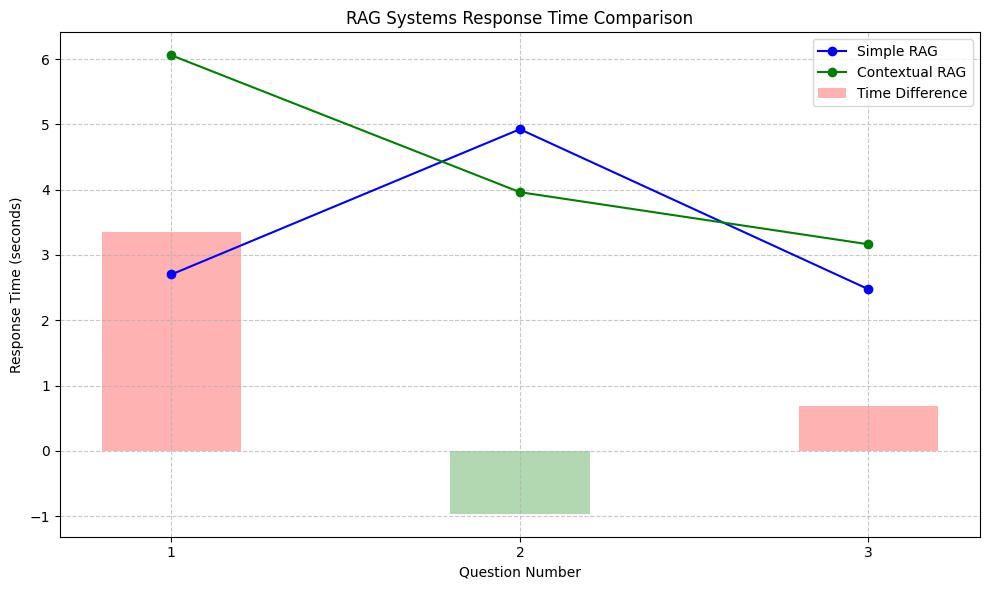

In [7]:
# Visualize response times
plt.figure(figsize=(10, 6))

# Prepare data for plotting
question_nums = range(1, len(questions) + 1)
simple_times = results_df["simple_time"].values
contextual_times = results_df["contextual_time"].values

# Create line chart
plt.plot(question_nums, simple_times, 'o-', color='blue', label='Simple RAG')
plt.plot(question_nums, contextual_times, 'o-', color='green', label='Contextual RAG')

# Add time difference as bar chart
time_diff = contextual_times - simple_times
colors = ['red' if x > 0 else 'green' for x in time_diff]
plt.bar(question_nums, time_diff, alpha=0.3, color=colors, width=0.4, label='Time Difference')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Question Number')
plt.ylabel('Response Time (seconds)')
plt.title('RAG Systems Response Time Comparison')
plt.xticks(question_nums)
plt.legend()

plt.tight_layout()
plt.show()

## 5. Feature Comparison Summary

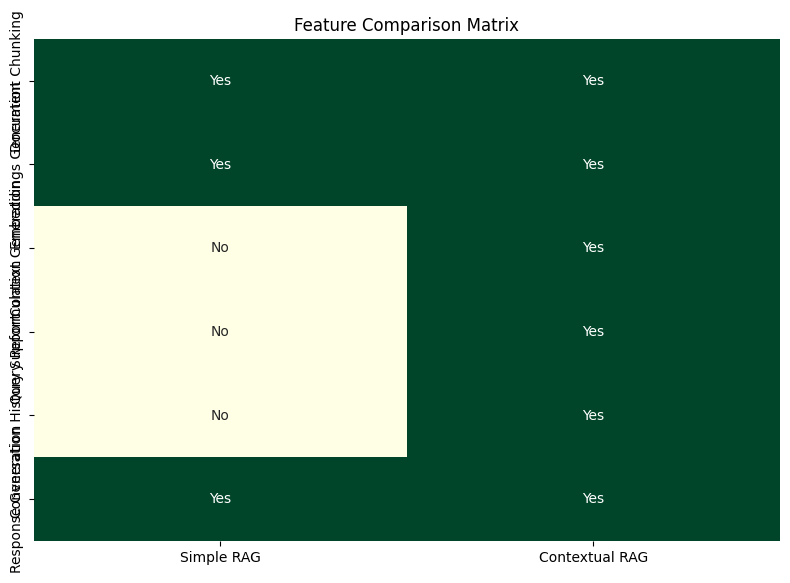

In [8]:
# Create a comparison matrix of features
features = [
    'Document Chunking',
    'Embeddings Generation',
    'Context Generation',
    'Query Reformulation',
    'Conversation History Support',
    'Response Generation'
]

simple_values = ['Yes', 'Yes', 'No', 'No', 'No', 'Yes']
contextual_values = ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']

# Create a heatmap
comparison_data = np.zeros((len(features), 2))
for i, (s, c) in enumerate(zip(simple_values, contextual_values)):
    comparison_data[i, 0] = 1 if s == 'Yes' else 0
    comparison_data[i, 1] = 1 if c == 'Yes' else 0

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(comparison_data, annot=np.array([simple_values, contextual_values]).T,
            cmap='YlGn', cbar=False, fmt='', ax=ax)

# Customize the plot
ax.set_xticklabels(['Simple RAG', 'Contextual RAG'])
ax.set_yticklabels(features)
ax.set_title('Feature Comparison Matrix')
plt.tight_layout()
plt.show()

## 6. Conclusion

**Key Differences:**

1. **Architectural Differences**: 
   - Simple RAG follows a straightforward pipeline: document loading, chunking, embedding, and retrieval.
   - Contextual RAG adds two critical enhancements: context generation during document processing and query reformulation during retrieval.

2. **Document Processing**:
   - Simple RAG stores chunks as they are.
   - Contextual RAG enriches chunks with additional context summaries, enhancing retrieval quality.

3. **Query Processing**:
   - Simple RAG uses queries directly for retrieval.
   - Contextual RAG can reformulate queries based on conversation history, leading to more relevant retrievals in multi-turn conversations.

4. **Performance Tradeoffs**:
   - Simple RAG is faster but may lack context awareness.
   - Contextual RAG has higher latency due to additional processing but potentially delivers more accurate and contextually relevant answers.

The choice between these systems depends on the specific use case, with Contextual RAG being more suitable for complex, conversational applications where context matters significantly.